<h1> AI2 Assignment </h1>
Jonathan Hanley - 117473096
<h3> Overview </h3>
For this assignment I am trying to create a classifier using <b>transfer learning </b> in order to classify hats. I have decided on 3 different types of hats the ushanka, flatcap and cowboy hat.

<h3> Import modules </h3>

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from PIL import Image, ImageFilter

import os

from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.models import load_model

from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import ResNet50, NASNetLarge
from tensorflow.keras.applications.resnet50 import preprocess_input 
from tensorflow.keras.applications.resnet50 import decode_predictions

<h3> Start Timimg </h3>
This notebook takes about 20 minutes

In [4]:
from time import time
start = time()

<h2> Load in the data </h2>
The is split into three directories train, val and test. Each one of these directories has three sub directories, one for each of the classes. <br>
Once the data is loaded in, take a look an example from each class. <br> 
Taking a look at the images we can see that the cowboy hat is pretty distenctive but it might be easy to mistake a ushanka for a flatcap or visa versa. I think the ushanka would be the hardest to predict becuase it comes in a lot of different shapes, colors and materials.

In [5]:
base_dir = ""
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

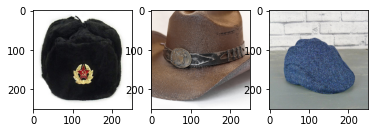

In [6]:
ushanka_dir = os.path.join(train_dir, "ushanka")
cowboy_dir = os.path.join(train_dir, "cowboy")
flatcap_dir = os.path.join(train_dir, "flatcap")
ushanka_filenames = [os.path.join(ushanka_dir, filename) for filename in os.listdir(ushanka_dir)]
cowboy_filenames = [os.path.join(cowboy_dir, filename) for filename in os.listdir(cowboy_dir)]
flatcap_filenames = [os.path.join(flatcap_dir, filename) for filename in os.listdir(flatcap_dir)]

i = 1
ushanka_example = load_img(ushanka_filenames[i], target_size=(250, 250))
cowboy_example = load_img(cowboy_filenames[i], target_size=(250, 250))
flatcap_example = load_img(flatcap_filenames[i], target_size=(250, 250))

plt.subplot(2, 3, i)
plt.imshow(ushanka_example)
plt.subplot(2, 3, i+1)
plt.imshow(cowboy_example)
plt.subplot(2, 3, i+2)
plt.imshow(flatcap_example)

<h1> Lets see how many images we have to work with </h1>

In [7]:
print("Ushanka: ", len(ushanka_filenames))
print("Cowboy: ", len(cowboy_filenames))
print("Flatcap: ", len(flatcap_filenames))

Ushanka:  105
Cowboy:  105
Flatcap:  105


105 images isn't a great amount to train with. I think it is worth over 
sampeling the datasets to increase the number of images available for training without accually having to get more images. I tried aumenting both within the DataGenerator and manualy. I got much better results on the training accuarcy, validation accuarcy, training loss and validation loss with the manual oversampeling so I decided to stay with the manual oversampeling.

<h1> Over Sampeling </h1>
<ol>
    <li> 
        Rotate each image within a random range. For example a hat rotated 15 degrees to the left still looks like a hat
    </li>
    <li> 
        Flip the image horozontaly. A hat that was pointing left, that is now pointing right still look like a hat.
    </li>
    <li>
        Make the image a bit blurry. A blurry hat still looks like a hat.
    </li>
</ol>

<h3> Rotate </h3>
I think the upper bound for roatating each image should be 45 degrees and the lower bound should be 10 degrees. I think these are good bounds because anything more than 45 degrees is a bit too much, no one wears a hat verticaly or upsidedown. Anything less than 10 degrees I think would be too little of a difference.

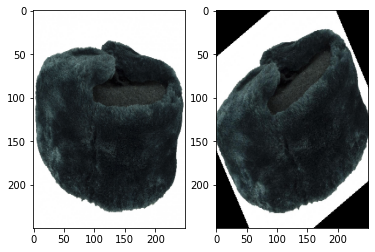

In [8]:
def rotate_image(path):
    degrees = randint(15, 45)
    if randint(0, 1):
        degrees = -degrees
    path_parts = path.split(".")
    #Adding this to the filename so the existing image isn't overwritten and I can also easily find the aumented images
    path_parts[0] += "-augmented-rotated."
    new_path = "".join(path_parts)
    og_image = Image.open(path)
    rotated_image = og_image.rotate(degrees)
    rotated_image.save(new_path)
    return new_path

old_path = ushanka_filenames[10]
new_path = rotate_image(old_path)

ushanka_old = load_img(old_path, target_size=(250, 250))
ushanka_new = load_img(new_path, target_size=(250, 250))

plt.subplot(1, 2, 1)
plt.imshow(ushanka_old, aspect="auto")
plt.subplot(1, 2, 1+1)
plt.imshow(ushanka_new, aspect="auto")

os.remove(new_path)

<h3>Flip Horozontaly</h3>
This flips the way that the hat is pointing by 180%. This is not the same as rotating.

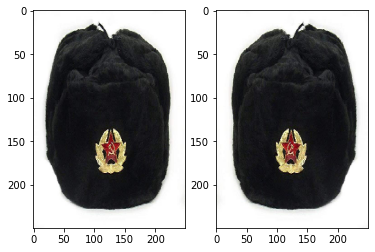

In [9]:
def flip_image(path):
    path_parts = path.split(".")
    #Adding this to the filename so the existing image isn't overwritten and I can also easily find the aumented images
    path_parts[0] += "-augmented-flipped."
    new_path = "".join(path_parts)
    og_image = Image.open(path)
    flipped = og_image.transpose(Image.FLIP_LEFT_RIGHT)
    flipped.save(new_path)
    return new_path

old_path = ushanka_filenames[1]
new_path = flip_image(old_path)

ushanka_old = load_img(old_path, target_size=(250, 250))
ushanka_new = load_img(new_path, target_size=(250, 250))
plt.subplot(1, 2, 1)
plt.imshow(ushanka_old, aspect="auto")
plt.subplot(1, 2, 1+1)
plt.imshow(ushanka_new, aspect="auto")

os.remove(new_path)

<h3> Blur Image </h3>
Blurring the image sligtly. A blurry image of a hat still looks like a hat. It is better for real world uses too as it is not likley that all the iamges that will be classified will be sharp and professionaly taken.

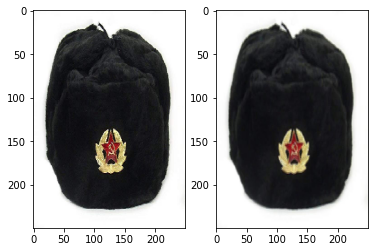

In [10]:
def blur_image(path):
    path_parts = path.split(".")
    #Adding this to the filename so the existing image isn't overwritten and I can also easily find the aumented images
    path_parts[0] += "-augmented-blurred."
    new_path = "".join(path_parts)
    og_image = Image.open(path)
    blurred_image = og_image.filter(ImageFilter.BLUR)
    blurred_image.save(new_path)
    return new_path

old_path = ushanka_filenames[1]
new_path = blur_image(old_path)

ushanka_old = load_img(old_path, target_size=(250, 250))
ushanka_new = load_img(new_path, target_size=(250, 250))

plt.subplot(1, 2, 1)
plt.imshow(ushanka_old, aspect="auto")
plt.subplot(1, 2, 1+1)
plt.imshow(ushanka_new, aspect="auto")

os.remove(new_path)

<h3> Augment all of the images in the trainin dataset </h3>
Now that the augment functions are working, we can augment the entire training set. I could blur all the images, then reload the file names, then rotate all the images including the new rotated images. Then repeat these steps for flipping the images. From the 105 images of training blurring would give us 210 images. Then rotating these images would give us 420 images. Finaly flipping these images would give us 840 images for each class. I decided against this as a lot of the these images are semetric. If an image is semetric then we would end up with "duplicate" images. For example if an image is semetric then when we flip it horozontaly, then we now have two dublicate images. Then when the image is blurred, this will result in two duplicate blurred images. When rotating the images, we will end up with 4 images of the same hat. The degree that is rotated by will likey by different for each image but never the less we will end up with the same hat rotated by 4 different amounts. 

---


By only performing the three augmentations to a single image and not augmenting an augmented image, the most duplicates we will end up is 2 for a single hat. This duplicate is the flipped image.

In [11]:
for x in ushanka_filenames:
    blur_image(x)
    rotate_image(x)
    flip_image(x)
    
for x in cowboy_filenames:
    blur_image(x)
    rotate_image(x)
    flip_image(x)
    
for x in flatcap_filenames:
    blur_image(x)
    rotate_image(x)
    flip_image(x)

Lets reload all the image names so we can see how many images belong to the training set of each class. 420 images is a nice improvement over the 110 we started with. This should help with overfitting later when we are training the model.

In [12]:
ushanka_filenames = [os.path.join(ushanka_dir, filename) for filename in os.listdir(ushanka_dir)]
cowboy_filenames = [os.path.join(cowboy_dir, filename) for filename in os.listdir(cowboy_dir)]
flatcap_filenames = [os.path.join(flatcap_dir, filename) for filename in os.listdir(flatcap_dir)]

print("Ushanka: ", len(ushanka_filenames))
print("Cowboy: ", len(cowboy_filenames))
print("Flatcap: ", len(flatcap_filenames))

Ushanka:  420
Cowboy:  420
Flatcap:  420


<h1> ResNet50 </h1>

Download the resnet50 model and save the base of it. I looked at different resnet models. Resnet 50 had the lowest amount of layers (50), I was hoping to find a resnet variant with less layers, this could have helped with the overfitting. Less layers means less parameters to learn and less paramters to learn reduces the complexty and the freedom the model has to wiggle though the noise and overfit.

In [13]:
resnet50_base = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
resnet50 = ResNet50(weights="imagenet", include_top=True)

102973440/102967424 [==============================] - 1s 0us/step


<h2> Check existsing resnet50 predictions on a few examples </h2>
For the ushanka class the resnet50 does not do a good job on predicting. This could be becuase a class for the ushanka was not included with the model was being trained.

40960/35363 [==================================] - 0s 0us/step


Text(0.5, 1.0, 'brassiere')

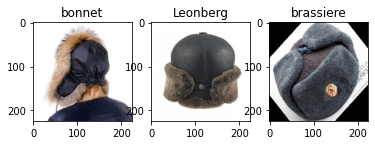

In [14]:
imgs = [load_img(img_path, target_size=(224, 224)) for img_path in ushanka_filenames][0:4]
img_tensor = np.array([img_to_array(img) for img in imgs])
img_tensor = preprocess_input(img_tensor)

# Predict
preds = resnet50.predict(img_tensor)
decoded_preds = decode_predictions(preds, top=3)
plt.subplot(1, 3, 1)
plt.imshow(imgs[1])
plt.title(decoded_preds[0][0][1])
plt.subplot(1, 3, 2)
plt.imshow(imgs[2])
plt.title(decoded_preds[1][0][1])
plt.subplot(1, 3, 3)
plt.imshow(imgs[3])
plt.title(decoded_preds[2][0][1])

The cowboy hat has much better success. It guesses two out of the three examples correctly. Even the image that is incorrectly guessed as a sombrero is still pretty good. A sombreoro is not too far from a coyboy hat. (Depending on how the dataset was loaded, it might also guess correctly on all three hats)

Text(0.5, 1.0, 'cowboy_hat')

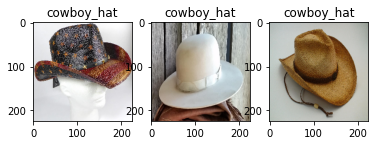

In [15]:
imgs = [load_img(img_path, target_size=(224, 224)) for img_path in cowboy_filenames][0:4]
img_tensor = np.array([img_to_array(img) for img in imgs])
img_tensor = preprocess_input(img_tensor)

# Predict
preds = resnet50.predict(img_tensor)
decoded_preds = decode_predictions(preds, top=3)
plt.subplot(1, 3, 1)
plt.imshow(imgs[1])
plt.title(decoded_preds[0][0][1])
plt.subplot(1, 3, 2)
plt.imshow(imgs[2])
plt.title(decoded_preds[1][0][1])
plt.subplot(1, 3, 3)
plt.imshow(imgs[3])
plt.title(decoded_preds[2][0][1])

Bad results again here for the flatcap. A microphone is a far guess from a cap. A purse is also a long shot. Again I think this is because when resent50 was being trained they didn't include a flatcap class.

Text(0.5, 1.0, 'doormat')

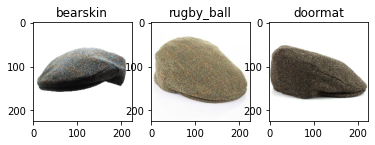

In [16]:
imgs = [load_img(img_path, target_size=(224, 224)) for img_path in flatcap_filenames][0:4]
img_tensor = np.array([img_to_array(img) for img in imgs])
img_tensor = preprocess_input(img_tensor)

# Predict
preds = resnet50.predict(img_tensor)
decoded_preds = decode_predictions(preds, top=3)
plt.subplot(1, 3, 1)
plt.imshow(imgs[1])
plt.title(decoded_preds[0][0][1])
plt.subplot(1, 3, 2)
plt.imshow(imgs[2])
plt.title(decoded_preds[1][0][1])
plt.subplot(1, 3, 3)
plt.imshow(imgs[3])
plt.title(decoded_preds[2][0][1])

<h2> Transfer learning </h2>
Lets use transfer learning to add our own classes to the resnet50 model. I am going to start very basic and just put a different output layer, just to see what happens.


In [17]:
def transfer_learning_nn_v1():
    network = Sequential()
    network.add(resnet50_base);
    resnet50_base.trainable = False
    network.add(Flatten())
    network.add(Dense(3, activation="softmax"))
    network.compile(optimizer=SGD(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
    return network

nn_v1 = transfer_learning_nn_v1()

When loading in the images I tried using my augmented images and I also tried loading in just the non augmented images and using the ImageDataGenerator to augment the images for me. I had much better succes using my own augmentation so I commented out the ImageDataGenerator augmentation.

In [18]:
im_size = 224
batch_size = 30
train_data_generator = ImageDataGenerator(rescale=1./255,
#                                             rotation_range=40,
#                                             width_shift_range=0.1,
#                                             height_shift_range=0.1,
#                                             shear_range=0.1,
#                                             zoom_range=0.1,
#                                             horizontal_flip=True,
#                                             fill_mode="nearest"
                                         )
train_generator = train_data_generator.flow_from_directory(
train_dir, target_size=( im_size,im_size), batch_size=batch_size, class_mode="categorical")

val_data_generator = ImageDataGenerator(rescale=1./255,
#                                             rotation_range=40,
#                                             width_shift_range=0.1,
#                                             height_shift_range=0.1,
#                                             shear_range=0.1,
#                                             zoom_range=0.1,
#                                             horizontal_flip=True,
#                                             fill_mode="nearest"
                                       )
val_generator = val_data_generator.flow_from_directory(
    val_dir, target_size=(im_size,im_size), batch_size=batch_size, class_mode="categorical")

test_data_generator = ImageDataGenerator(rescale=1./255,
#                                             rotation_range=40,
#                                             width_shift_range=0.1,
#                                             height_shift_range=0.1,
#                                             shear_range=0.1,
#                                             zoom_range=0.1,
#                                             horizontal_flip=True,
#                                             fill_mode="nearest"
                                        )
test_generator = test_data_generator.flow_from_directory(
test_dir, target_size=(im_size,im_size), batch_size=batch_size, class_mode="categorical")

Found 1260 images belonging to 3 classes.
Found 162 images belonging to 3 classes.
Found 166 images belonging to 3 classes.


In [19]:
steps_per_epoch = len(ushanka_filenames) // batch_size
# nn_v1_history = nn_v1.fit(
#                 train_generator, steps_per_epoch=steps_per_epoch, epochs=30, 
#                 validation_data=val_generator,
#                 callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
#                 verbose=1)

In [20]:
nn_v1_not_frozen_history = {'loss': [0.3161683976650238, 0.06757069379091263, 0.012053391896188259, 0.023865865543484688, 0.010286642238497734, 0.011041673831641674], 'accuracy': [0.9023809432983398, 0.9857142567634583, 0.9976190328598022, 0.9952380657196045, 0.9976190328598022, 0.9976190328598022], 'val_loss': [1.2359694242477417, 1.2341582775115967, 1.4411170482635498, 1.5236966609954834, 1.7284811735153198, 1.9112123250961304], 'val_accuracy': [0.31481480598449707, 0.4135802388191223, 0.40740740299224854, 0.35185185074806213, 0.37654322385787964, 0.40740740299224854]}
nn_v1_frozen_history = {'loss': [16.338016510009766, 14.007950782775879, 16.093711853027344, 9.16457462310791, 12.416906356811523, 6.090720176696777, 6.605004787445068, 6.8573760986328125, 4.08987283706665, 4.6432037353515625, 5.144230842590332, 5.660929203033447, 3.3834280967712402, 3.120133638381958, 5.272663593292236, 2.317991256713867], 'accuracy': [0.3523809611797333, 0.39523810148239136, 0.3523809611797333, 0.488095223903656, 0.4095238149166107, 0.5452380776405334, 0.538095235824585, 0.5523809790611267, 0.6285714507102966, 0.5976190567016602, 0.5761904716491699, 0.5809524059295654, 0.6499999761581421, 0.6928571462631226, 0.5952380895614624, 0.7214285731315613], 'val_loss': [17.867610931396484, 21.61946678161621, 15.157268524169922, 11.712437629699707, 4.544398307800293, 7.363382339477539, 8.304113388061523, 2.2326812744140625, 4.880656719207764, 5.689049243927002, 8.008306503295898, 1.2236638069152832, 3.8295345306396484, 1.4712363481521606, 1.3364893198013306, 1.2805904150009155], 'val_accuracy': [0.40740740299224854, 0.327160507440567, 0.3395061790943146, 0.35185185074806213, 0.5802469253540039, 0.46296295523643494, 0.4135802388191223, 0.6296296119689941, 0.604938268661499, 0.6296296119689941, 0.5925925970077515, 0.7777777910232544, 0.6481481194496155, 0.7469135522842407, 0.8333333134651184, 0.7654321193695068]}

nn_v1_not_frozen_loss = {"Training_loss": nn_v1_not_frozen_history["loss"],
           "Validation_loss":nn_v1_not_frozen_history["val_loss"]}

nn_v1_not_frozen_accuracy = {"Training_Accuracy": nn_v1_not_frozen_history["accuracy"],
           "Validation_Accuracy":nn_v1_not_frozen_history["val_accuracy"]}

nn_v1_frozen_loss = {"Training_loss": nn_v1_frozen_history["loss"],
           "Validation_loss":nn_v1_frozen_history["val_loss"]}

nn_v1_frozen_accuracy = {"Training_Accuracy": nn_v1_frozen_history["accuracy"],
           "Validation_Accuracy":nn_v1_frozen_history["val_accuracy"]}

The training accuarcy is very good, almost 100% correct but the validation data is shocking. It is very low in comparrision to the training accuarcy. This means it is overfitting a lot. This is because the model is too complex and has too much freedom to wiggle throught the noise. The model will need to be resreicted in order to reduce the complexity and therefor the freedom it has to wiggle though the noise.

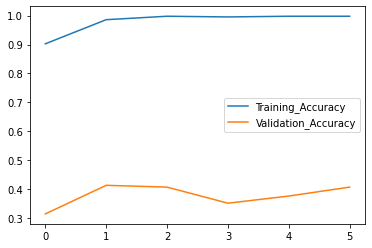

In [21]:
pd.DataFrame(nn_v1_not_frozen_accuracy).plot()

Again the training loss here is very good. Similarly to the validation accuarcy, the loss is very bad. This is becaue the model is over fitting. As the base of the resnet model is being trained there is a massive amount of parameters being trained. I will try with the base frozen so it does not have as many parameters to "learn".

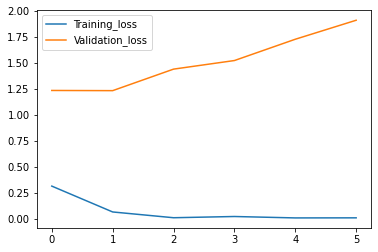

In [22]:
pd.DataFrame(nn_v1_not_frozen_loss).plot()

When the base is frozen there is very few parameters to learn. The only ones that need to be trained are the ones connecting the resnet base to the new top. This top is just "mapping" the resnet predictions to our three classes. 
The training accuarcy here is pretty good for the little work that has been done. The validation accuarcy too is pretty good. On the graph it appears to have a better score than the training data. This is because there is very few images in the validation data in comparrision to the training data and when the model is checking itself on the validation data, it may or may not get lucky.

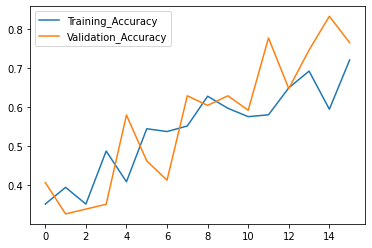

In [23]:
pd.DataFrame(nn_v1_frozen_accuracy).plot()

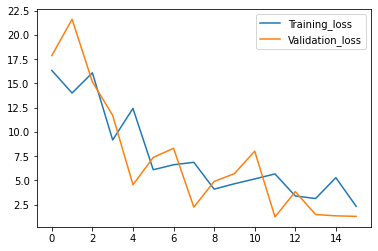

In [24]:
pd.DataFrame(nn_v1_frozen_loss).plot()

To impove the model above I will freeze the base, then add a new head onto the network. Once this is done I will recompile the model and refit it.
Once the model is done learning and I am happy with the results. I will unfreeze the base and then retrain the entire network using a much lower learning rate so that the prelearned weights will not be destroyed. <br>
With the simple network bellow I got an accuarcy of around 60% on the training data and 64% percent on the validation data. I think it got a higher accuarcy on the validation data because the validation set is much smaller than the training data and the model might just have gotten lucky on that one particualar epoch. The loss for this model was 0.85 on the training data and 0.77 on the validation data. Again I think this is because this given epoch was lucky when checking the model on the validation data.
<code>
def transfer_learning_nn_v2():
    network = Sequential()
    network.add(resnet50_base);
    resnet50_base.trainable = False
    network.add(Flatten())
    
    network.add(Dropout(0.5))
    network.add(Dense(128, activation="relu"))
    
    network.add(Dense(3, activation="softmax"))
    network.compile(optimizer=SGD(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
    return network  
</code>
<br>
The model is underfitting because both the training accuarcy and the validation accuarcy are both low and similar. I want to make the model more complex. I could reduce the drop out rate in the dropout layer, or I could add another layer to increase the complexity. I tried adding another dense layer with 256 neurons and the relu activation function.
<code>
  def transfer_learning_nn_v2():
    network = Sequential()
    network.add(resnet50_base);
    resnet50_base.trainable = False
    network.add(Flatten())

    network.add(Dropout(0.5))
    network.add(Dense(128, activation="relu"))
    network.add(Dense(256, activation="relu"))

    network.add(Dense(3, activation="softmax"))
    network.compile(optimizer=SGD(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
    return network
 </code>
 This network got a slightly worse accuarcy on both the training and validation data. I decided to try a differnt optimizer to see if this would make any difference. I have got good results with Adam in my FYP so I decided to try this. The adam optimizer is good for sparce and noisy datasets. Even after oversampling we have a low number of images to train on. I think adam will do good on this dataset. This is the model once I changed the optimizer to Adam.
<code>
def transfer_learning_nn_v2():
    network = Sequential()
    network.add(resnet50_base);
    resnet50_base.trainable = False
    network.add(Flatten())
    
    network.add(Dropout(0.5))
    network.add(Dense(128, activation="relu"))
    network.add(Dense(256, activation="relu"))

    network.add(Dense(3, activation="softmax"))
    network.compile(optimizer=Adam(
                  learning_rate=0.01,
                  name='Adam'
              ), loss="categorical_crossentropy", metrics=["accuracy"])
    return network
</code>
Good results here. This model got 87% on the training data and 86% on the validation data. Both the results are high and similar so the model is not overfitting. I want to see if I can get this a bit higher by adding another layer. This got a lower result on both the validation and training data. Adding another layer did not help so I tried to reduce the dropout rate from 0.5 to 0.3, 0.3 was not as good as 0.5 accuarcy wise so I then tried 0.4.<br>
0.4 got the best results so far 88% on both the validation data and training data. It had a loss of 0.29.<br>
The accuarcy was the same on both of datasets so I tried a drop out rate of 0.35 to see if I could get the accuarcy up top 90%. No joy this reduced the accuarcy and increased the loss. I noticed that the accuarcy increased quickly up to the 88ish% in the previous model but then fluctated around this for the last few epochs. I reduced the learning rate to 0.001 from 0.003 to see if this would help improve the results from the model. This got a slightly higher accuarcy on the validation data at 89% but a much higher accuarcy on the training data of 94%. So the model is now over fitting. I reduced the dropout rate back up to 0.4 to see if this would help. It did and it finished with the same 88%, 88% as I had before. I tried adding two more dense layers and the accuarcy 93% on the training dataset and 84 on the validation dataset. <br>
I changed the number of nurons in the second dense layer, and this fixed the overfitting, now both the training set and validation set get 89%. <br>
<b>I reduced the patience when training this model as I don't end up using it and I didn't want to waste time training it completly. Before reducing the patience, it was at 15 </b>

<code>
    def transfer_learning_nn_v2():
        network = Sequential()
        network.add(resnet50_base);
        resnet50_base.trainable = False
        network.add(Flatten())
        #network.add(Dropout(0.4))
        network.add(Dense(128, activation="relu"))
        network.add(Dense(3, activation="softmax"))
        network.compile(optimizer=Adam(
                      learning_rate=0.001,
                      name='Adam'
                  ), loss="categorical_crossentropy", metrics=["accuracy"])
        return network
</code>

In [25]:
def transfer_learning_nn_v2():
        network = Sequential()
        network.add(resnet50_base);
        resnet50_base.trainable = False
        network.add(Flatten())

        network.add(Dropout(0.5))
        network.add(Dense(128, activation="relu"))
        network.add(Dropout(0.15))
        network.add(Dense(256, activation="relu"))
        network.add(Dense(3, activation="softmax"))
        network.compile(optimizer=Adam(
                      learning_rate=0.001,
                      name='Adam'
                  ), loss="categorical_crossentropy", metrics=["accuracy"])
        return network

In [26]:
steps_per_epoch = len(ushanka_filenames) // batch_size
nn_v2 = transfer_learning_nn_v2()
nn_v2_history = nn_v2.fit(
        train_generator, steps_per_epoch=steps_per_epoch, epochs=100, 
        validation_data=val_generator,
        callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)],
        verbose=1
)

Epoch 1/100
14/14 [==============================] - 15s 895ms/step - loss: 4.2136 - accuracy: 0.3308 - val_loss: 0.9235 - val_accuracy: 0.5370
Epoch 2/100
14/14 [==============================] - 10s 743ms/step - loss: 1.1453 - accuracy: 0.4516 - val_loss: 0.8555 - val_accuracy: 0.6049
Epoch 3/100
14/14 [==============================] - 10s 706ms/step - loss: 1.0179 - accuracy: 0.4739 - val_loss: 0.7003 - val_accuracy: 0.7160
Epoch 4/100
14/14 [==============================] - 10s 742ms/step - loss: 0.7773 - accuracy: 0.6551 - val_loss: 0.6654 - val_accuracy: 0.6790
Epoch 5/100
14/14 [==============================] - 10s 744ms/step - loss: 0.7637 - accuracy: 0.6763 - val_loss: 0.6188 - val_accuracy: 0.7407
Epoch 6/100
14/14 [==============================] - 11s 775ms/step - loss: 0.6571 - accuracy: 0.7177 - val_loss: 0.5338 - val_accuracy: 0.7716
Epoch 7/100
14/14 [==============================] - 10s 745ms/step - loss: 0.5983 - accuracy: 0.7375 - val_loss: 0.5141 - val_accuracy:

When graphing the training accuarcy and the validation accuaracy, we can see that they both climb up and stay pretty similar thoughout the final 15 epochs. This means that the model isn't overfitting or underfitting

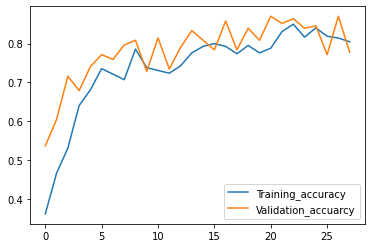

In [27]:
accuarcy = {"Training_accuracy": nn_v2_history.history["accuracy"],
           "Validation_accuarcy": nn_v2_history.history["val_accuracy"]}
pd.DataFrame(accuarcy).plot()

The loss here is also good. It starts high and then shoots rightdown. It continues to drop as the epochs continue.

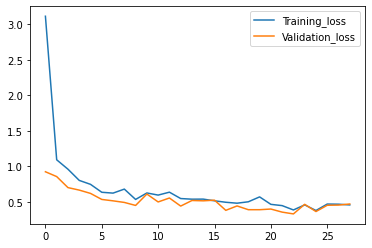

In [28]:
loss = {"Training_loss": nn_v2_history.history["loss"],
           "Validation_loss": nn_v2_history.history["val_loss"]}
pd.DataFrame(loss).plot()

In [29]:
resnet50_base.trainable = True
nn_v2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               12845184  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

When fine tuning the entire model, it begain overfitting. I stopped it after 4 epochs as it had a training accuarcy of 0.9 and a validation data of 0.3. There is too many layers being retrained and this is causing massive overfitting. I will iterate through the layers and set the last 10 to be trainable and see how I get on. <br>
By setting only the last 10 layers to be trainable, it reduced the amout that the model overfit by. It is still overfitting however. The model acheived a max of around 97% on the training data and 88% on the validation data.<br>
Next I tried to add a dropout layer of 0.25 to the top of the base to see if this would reduce the amount that the model is overfitting by. This helped a small bit but the model still reached 94% on the training data and again 88% on the validation data. I tried increasing the dropout rate to 0.5 but it was still overfitting. <br>
Next I added three dropout layers every second layer - overfitting 94% - 85%. Add more drop out layers - 96% - 90%. Try increasing the dropout to 0.5 for all the dropout layers but a similar result.  Reduced the number of trainable layers to the last 5 93% - 91%. Increasing the dropout to 0.6 gave a result of 0.93 and 0.92

In [30]:
resnet50_base.trainable = False
for layer in resnet50_base.layers[-5:]:
    layer.trainable = True
for i in range(-3, -45, -2):
    resnet50_base.layers.insert(i, Dropout(0.6))
resnet50_base.layers.append(Dropout(0.6))
nn_v2.compile(optimizer=Adam(
                  learning_rate=0.0005,
                  name='Adam'), loss="categorical_crossentropy", metrics=["accuracy"])

In [31]:
nn_v2_tuned_history = nn_v2.fit(
                train_generator, steps_per_epoch=steps_per_epoch, epochs=100, 
                validation_data=val_generator,
                callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)],
                verbose=1)

Epoch 1/100
14/14 [==============================] - 14s 819ms/step - loss: 1.5619 - accuracy: 0.7451 - val_loss: 0.5626 - val_accuracy: 0.7716
Epoch 2/100
14/14 [==============================] - 10s 701ms/step - loss: 0.5774 - accuracy: 0.7608 - val_loss: 0.5668 - val_accuracy: 0.6790
Epoch 3/100
14/14 [==============================] - 11s 747ms/step - loss: 0.4167 - accuracy: 0.7971 - val_loss: 0.5530 - val_accuracy: 0.7469
Epoch 4/100
14/14 [==============================] - 10s 765ms/step - loss: 0.3978 - accuracy: 0.8424 - val_loss: 0.4914 - val_accuracy: 0.7778
Epoch 5/100
14/14 [==============================] - 10s 760ms/step - loss: 0.4046 - accuracy: 0.8233 - val_loss: 0.5738 - val_accuracy: 0.7160
Epoch 6/100
14/14 [==============================] - 10s 742ms/step - loss: 0.3624 - accuracy: 0.8550 - val_loss: 0.4696 - val_accuracy: 0.7531
Epoch 7/100
14/14 [==============================] - 10s 744ms/step - loss: 0.3514 - accuracy: 0.8379 - val_loss: 0.4960 - val_accuracy:

When plotting the accuarcy for this section of the training we can see that the accuarcy increases thoughout the training. For most of the training the training accuarcy looks might higher, but this is just because the graph is zoomed in, in reality there is only a couple of percentage inbetween them. These were much closer with a higher patience but again I didn't end up using this model, so I reduced the patience to shorten the length of time this notebook takes to execute.

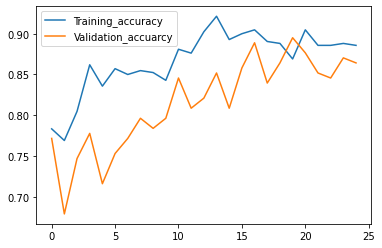

In [32]:
accuarcy = {"Training_accuracy": nn_v2_tuned_history.history["accuracy"],
           "Validation_accuarcy": nn_v2_tuned_history.history["val_accuracy"]}
pd.DataFrame(accuarcy).plot()

Similar situation here with the loss, both of the losses, continue to drop as the epochs progress. 

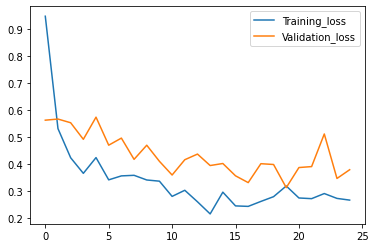

In [33]:
loss = {"Training_loss": nn_v2_tuned_history.history["loss"],
           "Validation_loss": nn_v2_tuned_history.history["val_loss"]}
pd.DataFrame(loss).plot()

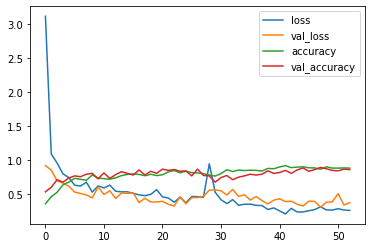

In [34]:
complete_history = {}
complete_history["loss"] = nn_v2_history.history["loss"] + nn_v2_tuned_history.history["loss"]
complete_history["val_loss"] = nn_v2_history.history["val_loss"] + nn_v2_tuned_history.history["val_loss"]
complete_history["accuracy"] = nn_v2_history.history["accuracy"] + nn_v2_tuned_history.history["accuracy"]
complete_history["val_accuracy"] = nn_v2_history.history["val_accuracy"] + nn_v2_tuned_history.history["val_accuracy"]
pd.DataFrame(complete_history).plot()

This is the best results I think I can get using the resnet50 model as a base. I had a look at other pretrained models within the keras libary. On the [keras page](https://keras.io/api/applications/) I saw that the NASNetLarge model had a good Top-1 Accuaracy and the best Top-5 accuaracy so I decided to see if I could get a better result than with the resnet50 model.

<h3>  NASNetLarge </h3>


Reload the images for the shape that NASNetLarge requires.

In [35]:
im_size = 331
batch_size = 30
nasnet_train_data_generator = ImageDataGenerator(rescale=1./255,)
nasnet_train_generator = nasnet_train_data_generator.flow_from_directory(
train_dir, target_size=( im_size,im_size), batch_size=batch_size, class_mode="categorical")

nasnet_val_data_generator = ImageDataGenerator(rescale=1./255,)
nasnet_val_generator = nasnet_val_data_generator.flow_from_directory(
    val_dir, target_size=(im_size,im_size), batch_size=batch_size, class_mode="categorical")

nasnet_test_data_generator = ImageDataGenerator(rescale=1./255,)
nasnet_test_generator = nasnet_test_data_generator.flow_from_directory(
test_dir, target_size=(im_size,im_size), batch_size=batch_size, class_mode="categorical")

Found 1260 images belonging to 3 classes.
Found 162 images belonging to 3 classes.
Found 166 images belonging to 3 classes.


In [36]:
nasnet_base = NASNetLarge(weights="imagenet", include_top=False, input_shape=(331, 331, 3))

343613440/343610240 [==============================] - 3s 0us/step


I just copied and pasted the previous model but changed the base so it was nasnetLarge. This get very good results but it was overfitting slightly. It got 100% on the training data and 98% on the validation data.<br>
<code>
  def transfer_learning_nn_v3():

        network = Sequential()
        network.add(nasnet_base)
        nasnet_base.trainable = False
        network.add(Flatten())
        network.add(Dropout(0.5))
        network.add(Dense(128, activation="relu"))
        network.add(Dropout(0.15))
        network.add(Dense(256, activation="relu"))
        network.add(Dense(3, activation="softmax"))
        network.compile(optimizer=Adam(
                      learning_rate=0.001,
                      name='Adam'
                  ), loss="categorical_crossentropy", metrics=["accuracy"])
        return network
</code><br>
To fix the overfitting, I increased the dropout rate in the second Dropout layer so that it was 0.4. This got a much better result of 99% and 98%. I tried increasing the dropout rate up to 0.5. I still got the same issue with slight over fitting. The loss is also pretty high on the validation data(around 0.8) so I decided to remove the final dense layer before the output layer. It got pretty much the same result. I will keep this as it is and see if I can reduce the overfitting by adding some dropout layers to the base.

In [37]:
def transfer_learning_nn_v3():
        network = Sequential()
        network.add(nasnet_base)
        nasnet_base.trainable = False
        network.add(Flatten())

        network.add(Dropout(0.5))
        network.add(Dense(128, activation="relu"))
        network.add(Dropout(0.5))
        network.add(Dense(3, activation="softmax"))
        network.compile(optimizer=Adam(
                      learning_rate=0.001,
                      name='Adam'
                  ), loss="categorical_crossentropy", metrics=["accuracy"])
        return network

In [38]:
steps_per_epoch = len(ushanka_filenames) // batch_size
nn_v3 = transfer_learning_nn_v3()
nn_v3_history = nn_v3.fit(
        nasnet_train_generator, steps_per_epoch=steps_per_epoch, epochs=100, 
        validation_data=nasnet_val_generator,
        callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)],
        verbose=1
)

Epoch 1/100
14/14 [==============================] - 36s 2s/step - loss: 4.9877 - accuracy: 0.7900 - val_loss: 9.8459 - val_accuracy: 0.9444
Epoch 2/100
14/14 [==============================] - 17s 1s/step - loss: 2.9605 - accuracy: 0.9629 - val_loss: 1.6892 - val_accuracy: 0.9630
Epoch 3/100
14/14 [==============================] - 17s 1s/step - loss: 1.7010 - accuracy: 0.9747 - val_loss: 0.8703 - val_accuracy: 0.9815
Epoch 4/100
14/14 [==============================] - 17s 1s/step - loss: 0.0805 - accuracy: 0.9915 - val_loss: 1.1321 - val_accuracy: 0.9753
Epoch 5/100
14/14 [==============================] - 17s 1s/step - loss: 0.4884 - accuracy: 0.9875 - val_loss: 1.4882 - val_accuracy: 0.9691
Epoch 6/100
14/14 [==============================] - 17s 1s/step - loss: 0.2826 - accuracy: 0.9906 - val_loss: 1.0168 - val_accuracy: 0.9753
Epoch 7/100
14/14 [==============================] - 17s 1s/step - loss: 0.2248 - accuracy: 0.9876 - val_loss: 0.6261 - val_accuracy: 0.9815
Epoch 8/100
1

I added every second layer as a dropout layer, with a dropout of 0.2. I did this in reverse because the indexing would mess up if I was starting at the first layer. The model was still over fitting with a loss of 0.2 so I increased it to 0.3, then 0.4 and finaly 0.5 until this reduced the overfitting to an acceptable level.

In [39]:
for i in range(len(nasnet_base.layers), 1, -2):
    nasnet_base.layers.insert(i, Dropout(0.5))
nn_v3.compile(optimizer=Adam(
                  learning_rate=0.0005,
                  name='Adam'), loss="categorical_crossentropy", metrics=["accuracy"])
nn_v3_tuned_history = nn_v3.fit(
                nasnet_train_generator, steps_per_epoch=steps_per_epoch, epochs=100, 
                validation_data=nasnet_val_generator,
                callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)],
                verbose=1)

Epoch 1/100
14/14 [==============================] - 35s 2s/step - loss: 0.1929 - accuracy: 0.9960 - val_loss: 0.8671 - val_accuracy: 0.9815
Epoch 2/100
14/14 [==============================] - 17s 1s/step - loss: 0.0269 - accuracy: 0.9984 - val_loss: 1.5053 - val_accuracy: 0.9753
Epoch 3/100
14/14 [==============================] - 17s 1s/step - loss: 0.0468 - accuracy: 0.9991 - val_loss: 1.0760 - val_accuracy: 0.9815
Epoch 4/100
14/14 [==============================] - 17s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.3403 - val_accuracy: 0.9877
Epoch 5/100
14/14 [==============================] - 18s 1s/step - loss: 0.2859 - accuracy: 0.9949 - val_loss: 0.8077 - val_accuracy: 0.9815
Epoch 6/100
14/14 [==============================] - 17s 1s/step - loss: 0.1164 - accuracy: 0.9886 - val_loss: 1.2433 - val_accuracy: 0.9753
Epoch 7/100
14/14 [==============================] - 18s 1s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.7050 - val_accuracy: 0.9877
Epoch 8/1

<h3> Testing </h3>

In [40]:
nn_v2_test_loss, nn_v2_test_acc = nn_v2.evaluate(test_generator)
nn_v2_test_loss

6/6 [==============================] - 3s 507ms/step - loss: 0.2580 - accuracy: 0.9157


0.25795528292655945

In [41]:
nn_v3_test_loss, nn_v3_test_acc = nn_v3.evaluate(nasnet_test_generator)
nn_v3_test_acc

6/6 [==============================] - 6s 875ms/step - loss: 0.1505 - accuracy: 0.9880


0.9879518151283264

The nasnet model had a better accuarcy on the test data over the resnet model but the resnet model had a much lower loss. I decided to use the nasnet model because of the higher accuarcy

In [42]:
nn_v3.save("best_network.h5")

<h1> Clean Dataset </h1>
Remove all the augmented images.

In [43]:
base = "train/"
dirs = ["ushanka", "cowboy", "flatcap"]
for d in dirs:
    path = os.path.join(base, d)
    print(path)
    c = 0
    for file in os.listdir(path):
        if "augmented" in file:
            os.remove(os.path.join(path, file))
            c += 1
            
    print("{} files removed from {}".format(c, d))

train/ushanka
315 files removed from ushanka
train/cowboy
315 files removed from cowboy
train/flatcap
315 files removed from flatcap


In [44]:
end = time() - start
print(end / 60)

19.02054374217987
